# Week 2 — Exploratory Data Analysis (EDA): SLA Breach Drivers

**Goal (No ML yet):** Understand **where** SLA breaches happen and **why** they happen, using **only the cleaned dataset** from Week 1.

**Dataset required:** `week1_cleaned_data.csv`  
> If this file is not found in your Colab runtime, the notebook will (optionally) recreate it from the raw file (for convenience) and save it as `week1_cleaned_data.csv`.  
> **For submission, upload and use your Week 1 cleaned file.**

**Allowed visuals:** bar charts, box plots, heatmaps, scatter plots  
🚫 No dashboards • 🚫 No feature engineering • 🚫 No ML models


In [2]:
# ==========================================================
# 0) Setup
# ==========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

# Paths (Colab)
CLEAN_PATH = "/content/week1_cleaned_data.csv"

# Optional raw fallback (only used if CLEAN_PATH not found)
RAW_FALLBACKS = ["/content/b2b_sla_logistics_dataset_200k.csv"
]

def _first_existing(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return None


In [3]:
# ==========================================================
# 1) Load Week 1 cleaned dataset (REQUIRED)
# ==========================================================
if os.path.exists(CLEAN_PATH):
    df = pd.read_csv(CLEAN_PATH)
    print(f"✅ Loaded cleaned data: {CLEAN_PATH}")
else:
    print("⚠️ week1_cleaned_data.csv not found at /content/.")
    print("   For submission, you MUST use the Week 1 cleaned file.")
    print("   This notebook will now try to recreate a cleaned file from the raw dataset (convenience fallback).")

    raw_path = _first_existing(RAW_FALLBACKS)
    if raw_path is None:
        raise FileNotFoundError(
            "Neither week1_cleaned_data.csv nor the raw fallback file was found. "
            "Upload week1_cleaned_data.csv to Colab (/content/) and re-run."
        )
    print(f"➡️ Using raw fallback: {raw_path}")
    df_raw = pd.read_csv(raw_path)

    # ------------------------------------------------------
    # Week 1-style cleaning (minimal, reproducible)
    # ------------------------------------------------------
    df = df_raw.copy()

    # 1) Drop duplicates
    df = df.drop_duplicates()

    # 2) Standardize column names (optional safety)
    df.columns = [c.strip() for c in df.columns]

    # 3) Ensure key numeric columns are numeric (coerce errors)
    numeric_cols = [
        "shipping_cost_usd", "shipment_weight_kg", "shipment_volume_cbm",
        "delivery_delay_days"
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # 4) Target / label: sla_breach_flag (must exist for Week 2)
    if "sla_breach_flag" not in df.columns:
        # Try common alternatives
        alt = [c for c in df.columns if c.lower() in ["sla_breach", "sla_breach_flag", "breach_flag", "sla_breach_ind"]]
        if alt:
            df = df.rename(columns={alt[0]: "sla_breach_flag"})
        else:
            raise KeyError("Target column 'sla_breach_flag' not found. Please use your Week 1 cleaned file.")

    # Make target binary 0/1
    df["sla_breach_flag"] = pd.to_numeric(df["sla_breach_flag"], errors="coerce")
    df = df[df["sla_breach_flag"].isin([0, 1])]

    # 5) Handle missing values (no feature creation; just impute)
    #    - numeric: median
    for col in numeric_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())

    #    - categorical: mode
    cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode(dropna=True)[0] if not df[col].mode(dropna=True).empty else "Unknown")

    # 6) Winsorize numeric columns (1st–99th percentile)
    for col in numeric_cols:
        if col in df.columns:
            lo, hi = df[col].quantile([0.01, 0.99])
            df[col] = df[col].clip(lo, hi)

    # Save recreated cleaned file
    df.to_csv(CLEAN_PATH, index=False)
    print(f"✅ Recreated and saved cleaned data to: {CLEAN_PATH}")

print("Shape:", df.shape)
df.head()


⚠️ week1_cleaned_data.csv not found at /content/.
   For submission, you MUST use the Week 1 cleaned file.
   This notebook will now try to recreate a cleaned file from the raw dataset (convenience fallback).
➡️ Using raw fallback: /content/b2b_sla_logistics_dataset_200k.csv
✅ Recreated and saved cleaned data to: /content/week1_cleaned_data.csv
Shape: (200000, 21)


,shipment_id,carrier,shipping_mode,region,origin_country,destination_country,shipment_weight_kg,shipment_volume_cbm,priority_flag,fragile_flag,temperature_control_flag,planned_delivery_days,actual_delivery_days,delivery_delay_days,sla_breach_flag,shipping_cost_usd,fuel_surcharge_pct,customs_delay_flag,weather_disruption_flag,shipment_value_usd,insurance_flag
0,SHP_1000000,Carrier_H,Rail,EMEA,France,UK,9256.28,100.28,0,0,1,23,24.0,1.0,1,9531.05,20.18,1,0,48235.35,0
1,SHP_1000001,Carrier_E,Rail,APAC,Vietnam,UK,11026.85,85.39,0,0,0,39,36.0,-3.0,0,6249.19,24.71,0,0,44935.84,1
2,SHP_1000002,Carrier_B,Road,AMER,Vietnam,Germany,9126.25,137.58,0,0,0,7,7.0,0.0,0,11949.56,12.06,0,0,90132.88,0
3,SHP_1000003,Carrier_G,Road,AMER,Mexico,USA,6327.51,51.24,0,0,0,18,15.0,-3.0,0,11227.29,23.35,0,0,84935.19,1
4,SHP_1000004,Carrier_D,Road,EMEA,Poland,China,8850.45,109.66,0,0,0,19,20.0,1.0,1,9746.15,11.44,0,0,62812.24,0


## Quick sanity checks (cleaned dataset)

We confirm:
- No duplicate rows
- Target column exists and is binary
- Numeric columns are valid


In [4]:
# Duplicates
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

# Target distribution
if "sla_breach_flag" in df.columns:
    print("\nTarget (sla_breach_flag) value counts:")
    print(df["sla_breach_flag"].value_counts(dropna=False))
    print("\nTarget rate (mean breach rate):", round(df["sla_breach_flag"].mean(), 4))

# Missing values snapshot (top 20)
na = df.isna().sum().sort_values(ascending=False)
print("\nTop missing columns (should be low/zero):")
display(na.head(20))


Duplicate rows: 0

Target (sla_breach_flag) value counts:
sla_breach_flag
0    105529
1     94471
Name: count, dtype: int64

Target rate (mean breach rate): 0.4724

Top missing columns (should be low/zero):


,0
shipment_id,0
carrier,0
shipping_mode,0
region,0
origin_country,0
destination_country,0
shipment_weight_kg,0
shipment_volume_cbm,0
priority_flag,0
fragile_flag,0


✅ df detected — running quick demo plots...


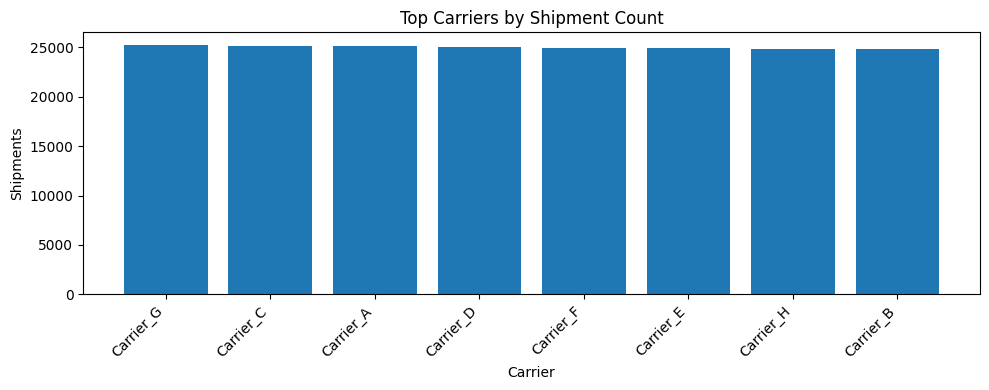

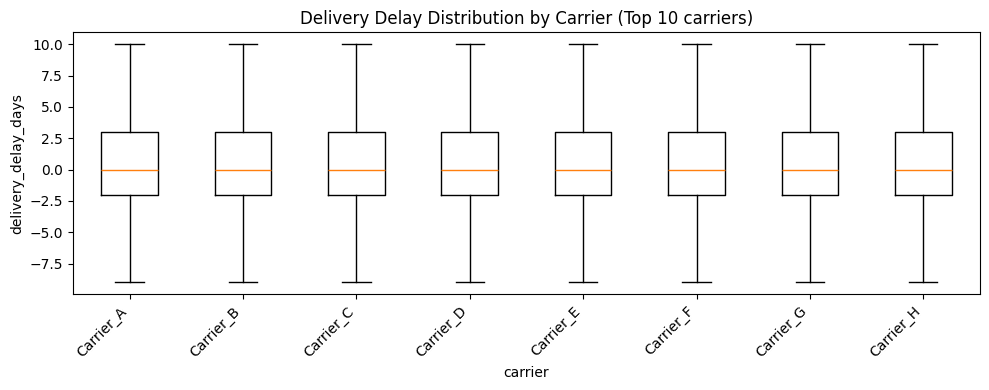

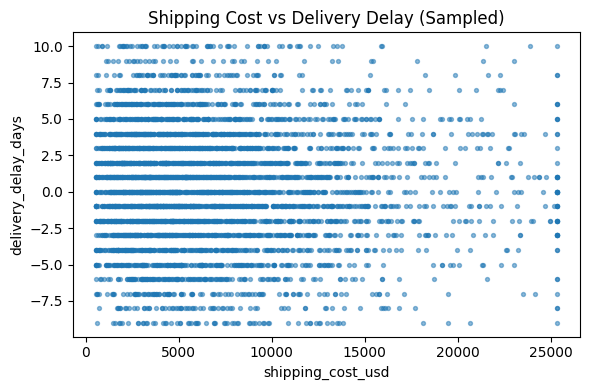

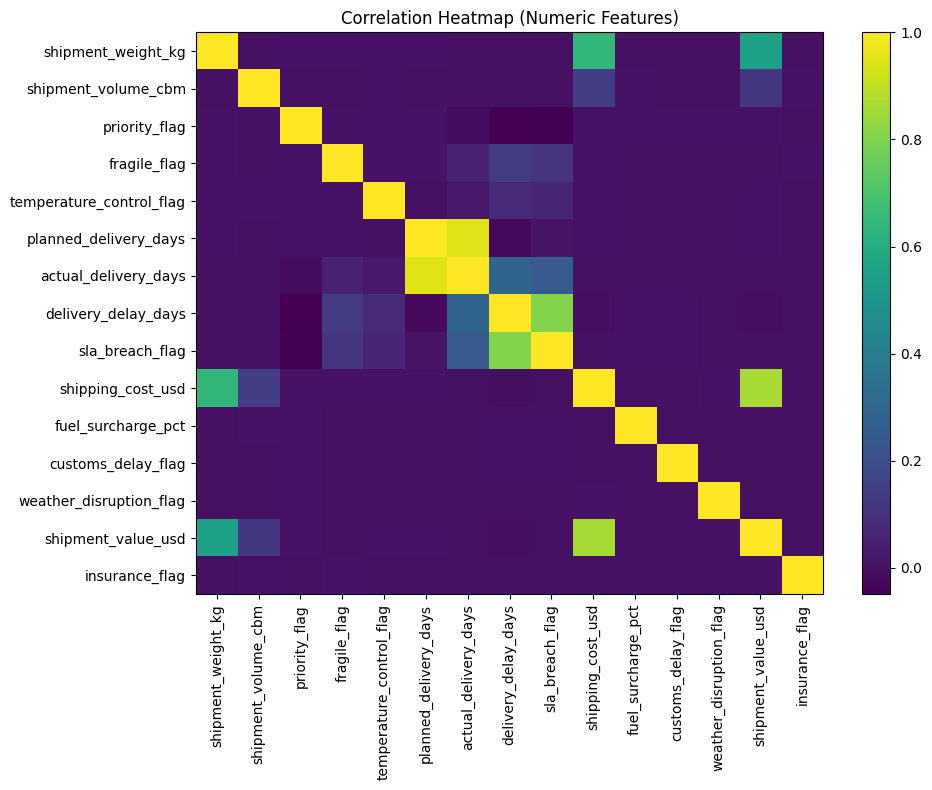

In [7]:
# ==========================================================
# Helper functions for EDA (Colab-ready + auto-demo)
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_bar(series, title, xlabel="", ylabel="Count", top_n=20, rotate=45, sort=True):
    """
    series: pd.Series with index=category and values=count/metric
    """
    s = series.copy()

    # Convert to Series if needed
    if not isinstance(s, pd.Series):
        s = pd.Series(s)

    # Optional sorting (descending)
    if sort:
        s = s.sort_values(ascending=False)

    # Keep top N
    if top_n is not None and len(s) > top_n:
        s = s.head(top_n)

    plt.figure(figsize=(10, 4))
    plt.bar(s.index.astype(str), s.values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotate, ha="right")
    plt.tight_layout()
    plt.show()


def plot_box(df, x_col, y_col, title, rotate=45, top_n=20, sort_by="median"):
    """
    Boxplot of y_col grouped by x_col.
    Limits categories to top_n for readability (by count).
    """
    if x_col not in df.columns or y_col not in df.columns:
        raise KeyError(f"Missing columns. Needed: {x_col}, {y_col}")

    tmp = df[[x_col, y_col]].dropna().copy()

    # Ensure numeric y
    tmp[y_col] = pd.to_numeric(tmp[y_col], errors="coerce")
    tmp = tmp.dropna(subset=[y_col])

    # Reduce categories to top_n by frequency (readability)
    if top_n is not None:
        top_cats = tmp[x_col].value_counts().head(top_n).index
        tmp = tmp[tmp[x_col].isin(top_cats)]

    groups = []
    labels = []
    for k, g in tmp.groupby(x_col):
        vals = g[y_col].dropna().values
        if len(vals) > 0:
            groups.append(vals)
            labels.append(str(k))

    # Optional sorting of labels for nicer plot
    if sort_by in ["median", "mean"]:
        stats = []
        for lab, vals in zip(labels, groups):
            stats.append((lab, np.median(vals) if sort_by == "median" else np.mean(vals)))
        stats = sorted(stats, key=lambda x: x[1], reverse=True)
        labels = [x[0] for x in stats]
        groups = [groups[[str(l) for l in labels].index(lab)] for lab in labels]  # reorder safely

    plt.figure(figsize=(10, 4))
    plt.boxplot(groups, tick_labels=labels, showfliers=False)
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.xticks(rotation=rotate, ha="right")
    plt.tight_layout()
    plt.show()


def plot_scatter(df, x, y, title, sample=5000):
    """
    Scatter plot with optional sampling for speed on large datasets.
    """
    if x not in df.columns or y not in df.columns:
        raise KeyError(f"Missing columns. Needed: {x}, {y}")

    tmp = df[[x, y]].copy()

    # Convert to numeric if possible
    tmp[x] = pd.to_numeric(tmp[x], errors="coerce")
    tmp[y] = pd.to_numeric(tmp[y], errors="coerce")
    tmp = tmp.dropna()

    if sample is not None and len(tmp) > sample:
        tmp = tmp.sample(sample, random_state=42)

    plt.figure(figsize=(6, 4))
    plt.scatter(tmp[x], tmp[y], s=8, alpha=0.5)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.tight_layout()
    plt.show()


def plot_heatmap(corr_df, title):
    """
    corr_df: correlation DataFrame
    """
    if not isinstance(corr_df, pd.DataFrame):
        raise TypeError("corr_df must be a pandas DataFrame (e.g., df[numeric_cols].corr()).")

    plt.figure(figsize=(10, 8))
    plt.imshow(corr_df.values, aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation=90)
    plt.yticks(range(len(corr_df.index)), corr_df.index)
    plt.title(title)
    plt.tight_layout()
    plt.show()


# ==========================================================
# ✅ AUTO-DEMO (makes sure you SEE visuals when this cell runs)
# Only runs if df exists in your notebook
# ==========================================================
if "df" in globals() and isinstance(df, pd.DataFrame):
    print("✅ df detected — running quick demo plots...")

    # 1) Bar: top carriers by shipment count (if carrier column exists)
    if "carrier" in df.columns:
        plot_bar(df["carrier"].value_counts(), "Top Carriers by Shipment Count", xlabel="Carrier", ylabel="Shipments", top_n=10)

    # 2) Box: delay by carrier (if both exist)
    if "carrier" in df.columns and "delivery_delay_days" in df.columns:
        plot_box(df, "carrier", "delivery_delay_days", "Delivery Delay Distribution by Carrier (Top 10 carriers)", top_n=10)

    # 3) Scatter: cost vs delay (if both exist)
    if "shipping_cost_usd" in df.columns and "delivery_delay_days" in df.columns:
        plot_scatter(df, "shipping_cost_usd", "delivery_delay_days", "Shipping Cost vs Delivery Delay (Sampled)")

    # 4) Heatmap: numeric correlation
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(num_cols) >= 2:
        corr = df[num_cols].corr(numeric_only=True)
        plot_heatmap(corr, "Correlation Heatmap (Numeric Features)")
else:
    print("ℹ️ df not found yet. Load your dataset first, then re-run this cell to see demo plots.")



# 1️⃣ SLA Breach Overview

We measure:
- Overall SLA breach rate
- Breach vs non-breach shipment counts
- Whether the target is imbalanced (simple rule-of-thumb: minority class < 20%)


Total shipments: 200,000
On-time (0): 105,529
Breach (1): 94,471
Overall breach rate: 47.236%
Minority class ratio: 47.236%
Imbalance check (<20% minority): ℹ️ Not strongly imbalanced


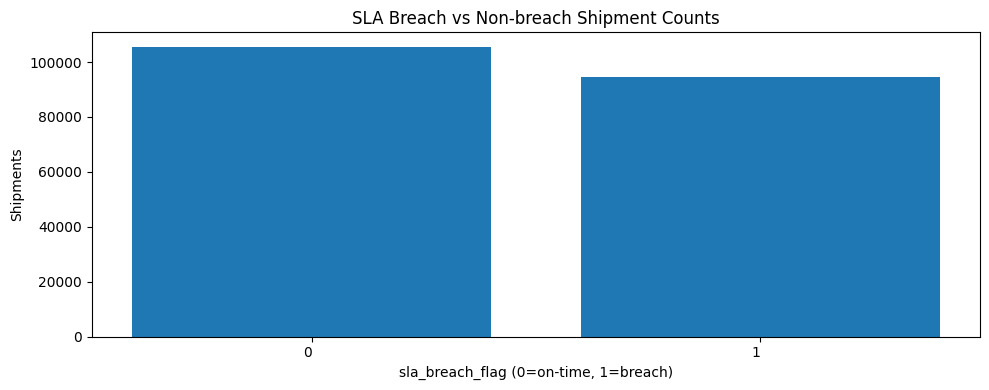

In [8]:
# Overall breach rate
breach_rate = df["sla_breach_flag"].mean()
counts = df["sla_breach_flag"].value_counts().sort_index()
total = len(df)

print(f"Total shipments: {total:,}")
print(f"On-time (0): {counts.get(0,0):,}")
print(f"Breach (1): {counts.get(1,0):,}")
print(f"Overall breach rate: {breach_rate:.3%}")

minority_ratio = min(counts.get(0,0), counts.get(1,0)) / total
print(f"Minority class ratio: {minority_ratio:.3%}")

imbalanced = minority_ratio < 0.20
print("Imbalance check (<20% minority):", "✅ Imbalanced" if imbalanced else "ℹ️ Not strongly imbalanced")

# Visual: breach vs non-breach
plot_bar(counts, title="SLA Breach vs Non-breach Shipment Counts", xlabel="sla_breach_flag (0=on-time, 1=breach)", ylabel="Shipments", top_n=None, rotate=0)


**Business interpretation:**  
A high breach rate suggests systemic reliability issues. If the target is imbalanced, later ML evaluation should prefer metrics like **ROC-AUC / Precision / Recall / F1**, not just accuracy.


# 2️⃣ Carrier-Level Analysis

We compute:
- **SLA breach rate by carrier**
- **Average delay by carrier**
- **Shipment volume handled by each carrier**

**Goal:** Identify **high-risk carriers** (high breach rate / high delay) and **stable carriers** (low breach rate / low delay).


,shipment_volume,breach_rate,avg_delay,median_delay
carrier,,,,
Carrier_C,25163,0.477805,0.331240,0.0
Carrier_D,24998,0.473958,0.302904,0.0
Carrier_B,24772,0.473599,0.305910,0.0
Carrier_F,24944,0.472458,0.282312,0.0
Carrier_G,25236,0.471905,0.307973,0.0
Carrier_E,24915,0.471523,0.282360,0.0
Carrier_H,24839,0.469383,0.259189,0.0
Carrier_A,25133,0.468189,0.264155,0.0


Min volume filter applied: 200 shipments
Carriers after filter: 8

🔴 Top 10 risky carriers (high breach rate):


,shipment_volume,breach_rate,avg_delay,median_delay
carrier,,,,
Carrier_C,25163,0.477805,0.331240,0.0
Carrier_D,24998,0.473958,0.302904,0.0
Carrier_B,24772,0.473599,0.305910,0.0
Carrier_F,24944,0.472458,0.282312,0.0
Carrier_G,25236,0.471905,0.307973,0.0
Carrier_E,24915,0.471523,0.282360,0.0
Carrier_H,24839,0.469383,0.259189,0.0
Carrier_A,25133,0.468189,0.264155,0.0



🟢 Top 10 stable carriers (low breach rate):


,shipment_volume,breach_rate,avg_delay,median_delay
carrier,,,,
Carrier_A,25133,0.468189,0.264155,0.0
Carrier_H,24839,0.469383,0.259189,0.0
Carrier_E,24915,0.471523,0.282360,0.0
Carrier_G,25236,0.471905,0.307973,0.0
Carrier_F,24944,0.472458,0.282312,0.0
Carrier_B,24772,0.473599,0.305910,0.0
Carrier_D,24998,0.473958,0.302904,0.0
Carrier_C,25163,0.477805,0.331240,0.0


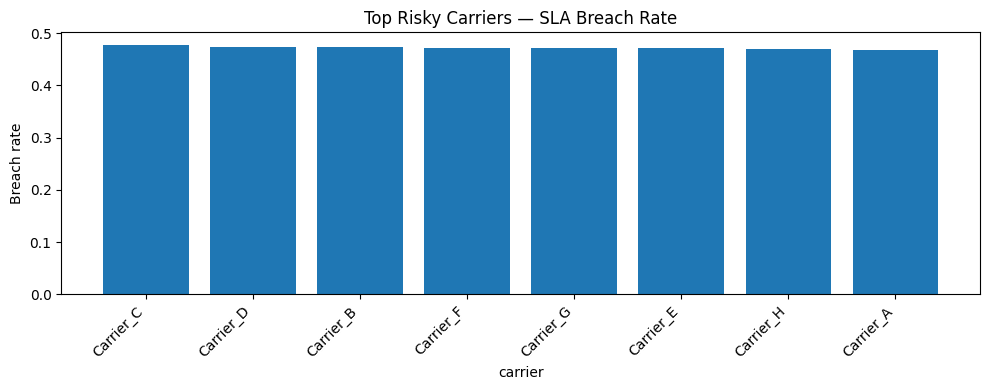

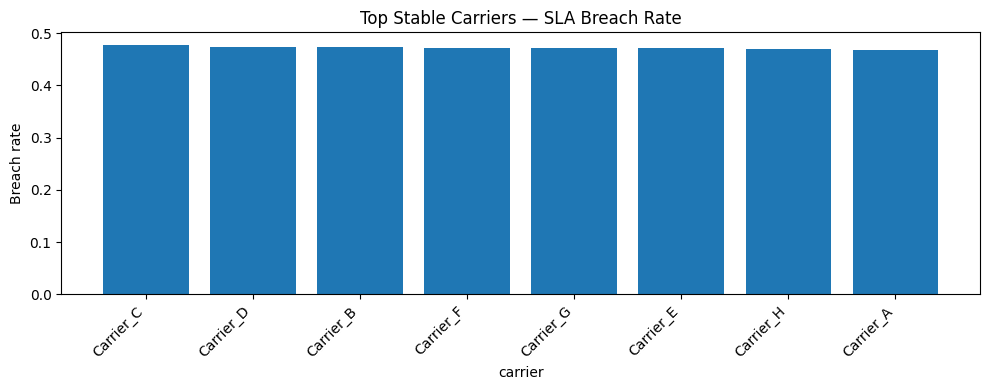

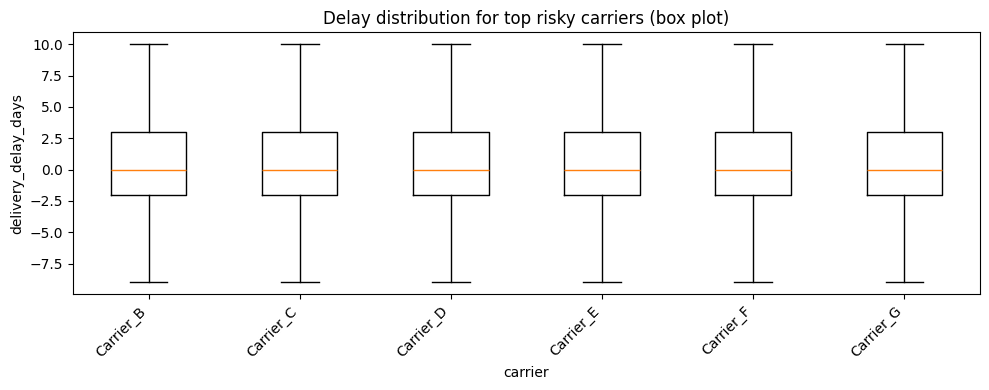

In [9]:
carrier_col_candidates = [c for c in df.columns if c.lower() in ["carrier", "carrier_name"]]
if not carrier_col_candidates:
    raise KeyError("Carrier column not found. Expected a column named 'carrier' in the cleaned dataset.")
carrier_col = carrier_col_candidates[0]

# Aggregations
carrier_stats = (
    df.groupby(carrier_col)
      .agg(
          shipment_volume=(carrier_col, "size"),
          breach_rate=("sla_breach_flag", "mean"),
          avg_delay=("delivery_delay_days", "mean"),
          median_delay=("delivery_delay_days", "median"),
      )
      .sort_values(["breach_rate", "avg_delay"], ascending=False)
)

display(carrier_stats.head(15))

# Top carriers by breach rate (min volume filter to avoid tiny-sample noise)
min_n = max(50, int(0.001 * len(df)))  # at least 50 shipments or 0.1% of dataset
carrier_stats_f = carrier_stats[carrier_stats["shipment_volume"] >= min_n].copy()

print(f"Min volume filter applied: {min_n} shipments")
print("Carriers after filter:", carrier_stats_f.shape[0])

top_risky = carrier_stats_f.sort_values(["breach_rate","avg_delay"], ascending=False).head(10)
top_stable = carrier_stats_f.sort_values(["breach_rate","avg_delay"], ascending=True).head(10)

print("\n🔴 Top 10 risky carriers (high breach rate):")
display(top_risky)

print("\n🟢 Top 10 stable carriers (low breach rate):")
display(top_stable)

# Visuals
plot_bar(top_risky["breach_rate"], title="Top Risky Carriers — SLA Breach Rate", xlabel=carrier_col, ylabel="Breach rate", top_n=None, rotate=45)
plot_bar(top_stable["breach_rate"], title="Top Stable Carriers — SLA Breach Rate", xlabel=carrier_col, ylabel="Breach rate", top_n=None, rotate=45)

# Box plot: delay distribution by top risky carriers
top_carriers = list(top_risky.index[:6])  # show 6 for readability
df_top = df[df[carrier_col].isin(top_carriers)]
plot_box(df_top, carrier_col, "delivery_delay_days", title="Delay distribution for top risky carriers (box plot)")


**Business interpretation:**  
- Carriers with high breach rate + high average delay are operationally risky.  
- Carriers with low breach rate + low delay are good candidates for preferred routing.  
- Always check shipment volume to avoid drawing conclusions from tiny samples.


# 3️⃣ Route & Transport Mode Analysis

We analyze:
- **SLA breach rate by shipping mode**
- **SLA breach rate by origin–destination routes**
- **Route × mode** comparison

**Goal:** Identify **risky modes**, **risky routes**, and combinations that consistently breach SLA.


,shipment_volume,breach_rate,avg_delay
shipping_mode,,,
Sea,60329,0.472890,0.296922
Road,79550,0.472822,0.290610
Air,40035,0.471962,0.287598
Rail,20086,0.469680,0.292044


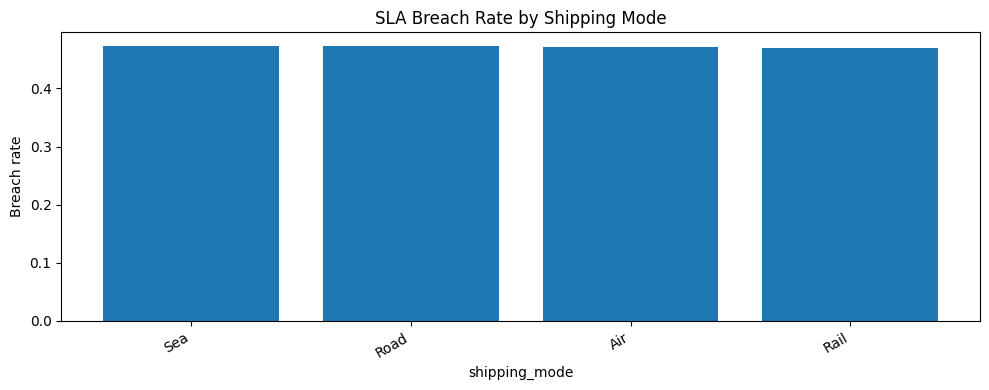

Min route volume filter: 100 shipments
Routes after filter: 100

🔴 Top risky routes:


,shipment_volume,breach_rate,avg_delay
_route,,,
Vietnam → Vietnam,1996,0.500501,0.448397
France → China,2081,0.497838,0.365209
UAE → UK,1999,0.497749,0.425713
Germany → China,2051,0.494881,0.474403
Mexico → India,2056,0.493191,0.428502
France → Mexico,1940,0.492784,0.297423
Mexico → France,1994,0.490471,0.431294
Germany → Germany,1970,0.489848,0.416244
USA → Poland,2081,0.488707,0.411821



🟢 Top stable routes:


,shipment_volume,breach_rate,avg_delay
_route,,,
Poland → UK,2002,0.449550,0.111389
UAE → USA,1987,0.452441,0.216910
France → Vietnam,1955,0.452685,0.149872
UK → Poland,1938,0.453560,0.158411
Mexico → UAE,2031,0.453964,0.164943
Poland → Mexico,2015,0.454591,0.170720
Mexico → China,2000,0.455000,0.155000
USA → USA,2004,0.455090,0.211577
Poland → Germany,1914,0.456113,0.128004


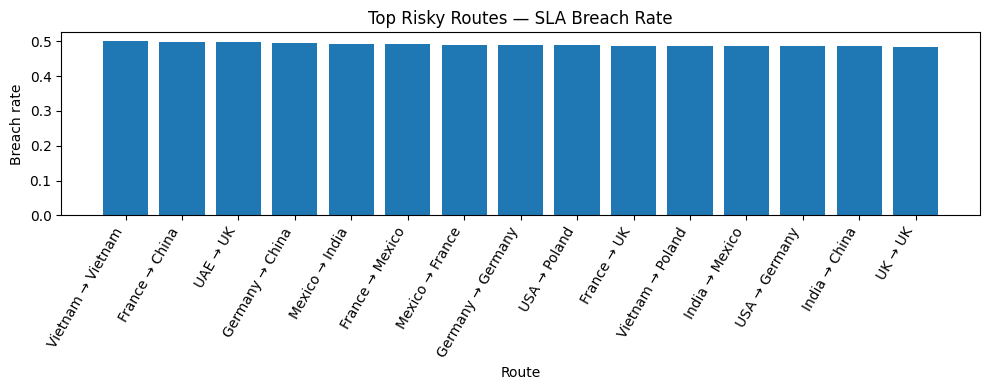

Min route×mode volume filter: 59 shipments

🔴 Top risky route × mode combinations:


,_route,shipping_mode,shipment_volume,breach_rate
397,Vietnam → Vietnam,Rail,209,0.564593
69,France → UK,Rail,194,0.546392
268,UAE → UK,Air,365,0.534247
1,China → China,Rail,179,0.530726
343,USA → Poland,Sea,596,0.523490
93,Germany → India,Rail,195,0.523077
4,China → France,Air,393,0.521628
37,China → Vietnam,Rail,213,0.521127
9,China → Germany,Rail,181,0.519337
41,France → China,Rail,214,0.518692


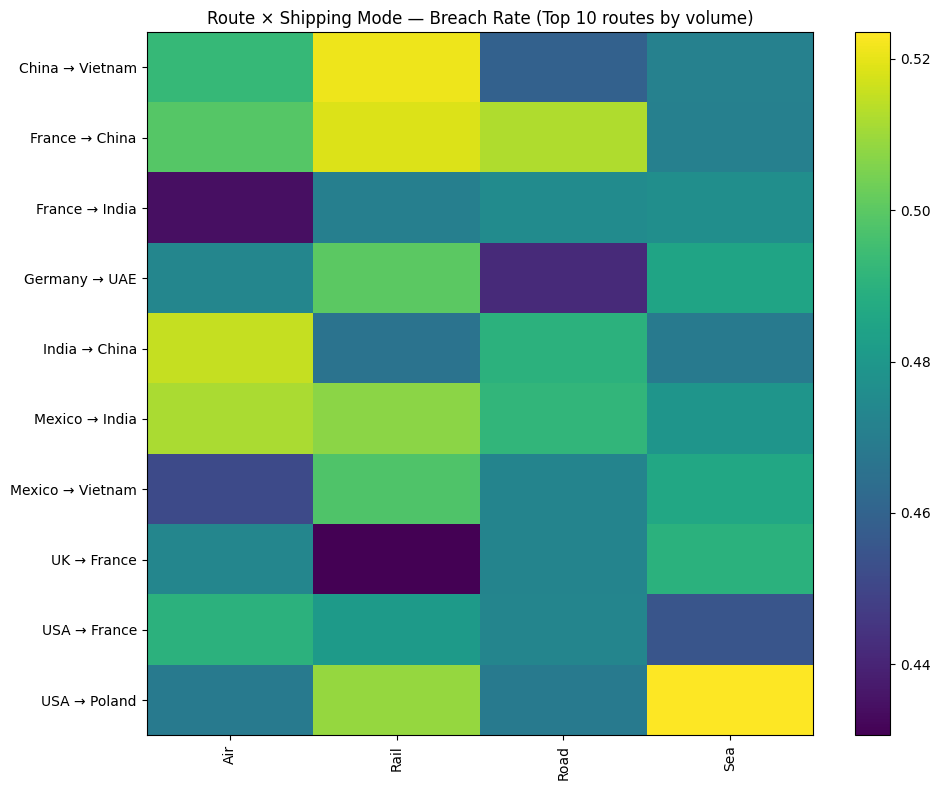

In [10]:
# Identify required columns
mode_col_candidates = [c for c in df.columns if c.lower() in ["shipping_mode", "mode", "transport_mode"]]
if not mode_col_candidates:
    raise KeyError("Shipping mode column not found. Expected 'shipping_mode' (or similar).")
mode_col = mode_col_candidates[0]

origin_candidates = [c for c in df.columns if c.lower() in ["origin_country", "origin", "origin_location"]]
dest_candidates = [c for c in df.columns if c.lower() in ["destination_country", "destination", "destination_location"]]
if not origin_candidates or not dest_candidates:
    raise KeyError("Origin/Destination columns not found. Expected 'origin_country' and 'destination_country' (or similar).")

origin_col = origin_candidates[0]
dest_col = dest_candidates[0]

# Breach rate by shipping mode
mode_stats = (
    df.groupby(mode_col)
      .agg(
          shipment_volume=(mode_col, "size"),
          breach_rate=("sla_breach_flag", "mean"),
          avg_delay=("delivery_delay_days", "mean"),
      )
      .sort_values(["breach_rate","avg_delay"], ascending=False)
)
display(mode_stats)

plot_bar(mode_stats["breach_rate"], title="SLA Breach Rate by Shipping Mode", xlabel=mode_col, ylabel="Breach rate", top_n=None, rotate=30)

# Route definition (no feature engineering beyond a label for grouping)
df["_route"] = df[origin_col].astype(str) + " → " + df[dest_col].astype(str)

route_stats = (
    df.groupby("_route")
      .agg(
          shipment_volume=("_route", "size"),
          breach_rate=("sla_breach_flag", "mean"),
          avg_delay=("delivery_delay_days", "mean"),
      )
      .sort_values(["breach_rate","avg_delay"], ascending=False)
)

# Filter routes to avoid tiny sample noise
min_route_n = max(30, int(0.0005 * len(df)))  # at least 30 shipments or 0.05%
route_stats_f = route_stats[route_stats["shipment_volume"] >= min_route_n].copy()

print(f"Min route volume filter: {min_route_n} shipments")
print("Routes after filter:", route_stats_f.shape[0])

top_routes_risky = route_stats_f.head(15)
top_routes_stable = route_stats_f.sort_values(["breach_rate","avg_delay"], ascending=True).head(15)

print("\n🔴 Top risky routes:")
display(top_routes_risky)

print("\n🟢 Top stable routes:")
display(top_routes_stable)

plot_bar(top_routes_risky["breach_rate"], title="Top Risky Routes — SLA Breach Rate", xlabel="Route", ylabel="Breach rate", top_n=15, rotate=60)

# Route × mode breach rate table (pivot)
route_mode = (
    df.groupby(["_route", mode_col])
      .agg(shipment_volume=("sla_breach_flag","size"), breach_rate=("sla_breach_flag","mean"))
      .reset_index()
)

# Keep only sufficiently large route-mode groups
min_rm_n = max(20, int(0.0003 * len(df)))
route_mode_f = route_mode[route_mode["shipment_volume"] >= min_rm_n].copy()

# Top risky route-mode combinations
top_route_mode = route_mode_f.sort_values(["breach_rate","shipment_volume"], ascending=[False, False]).head(20)
print(f"Min route×mode volume filter: {min_rm_n} shipments")
print("\n🔴 Top risky route × mode combinations:")
display(top_route_mode)

# Simple heatmap: pick top 10 routes by volume for readability
top10_routes = df["_route"].value_counts().head(10).index
rm_pivot = (
    df[df["_route"].isin(top10_routes)]
      .pivot_table(index="_route", columns=mode_col, values="sla_breach_flag", aggfunc="mean")
      .fillna(0)
)

plot_heatmap(rm_pivot, title="Route × Shipping Mode — Breach Rate (Top 10 routes by volume)")


**Business interpretation:**  
- A shipping mode with consistently higher breach rates indicates systemic constraints (lead time, handoffs, customs, capacity).  
- Risky routes often reflect cross-border complexity, distance, congestion, or local infrastructure.  
- Route × mode highlights the combinations to prioritize in the next phase (and to alert operations now).


# 4️⃣ Cost vs Reliability Analysis

We test the business assumption:

**Does paying more (higher shipping cost) reduce SLA breach risk?**

We compare:
- Shipping cost distributions for breach vs on-time
- Correlation between cost and delay
- Scatter plot: cost vs delay


Shipping cost summary by sla_breach_flag:


,count,mean,std,min,25%,50%,75%,max
sla_breach_flag,,,,,,,,
0,105529.0,6915.880741,4991.452745,545.5878,3262.350,5683.47,9277.26,25345.7787
1,94471.0,6883.862598,4964.322102,545.5878,3246.375,5672.56,9228.38,25345.7787


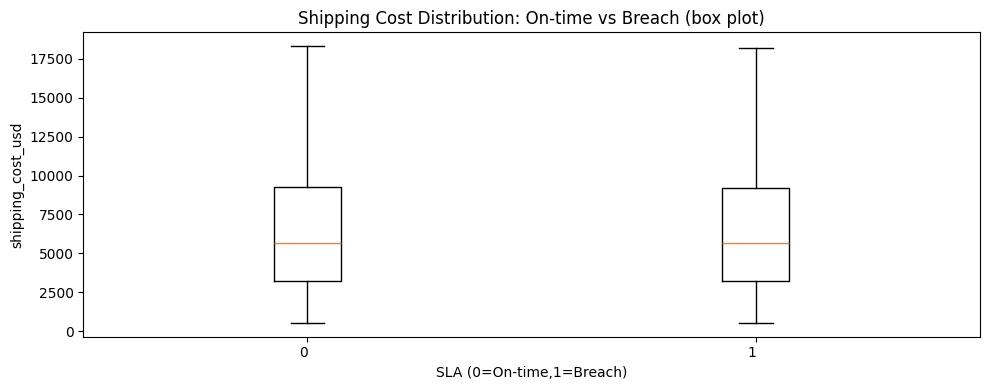

Correlation (shipping_cost_usd vs delivery_delay_days): -0.0047


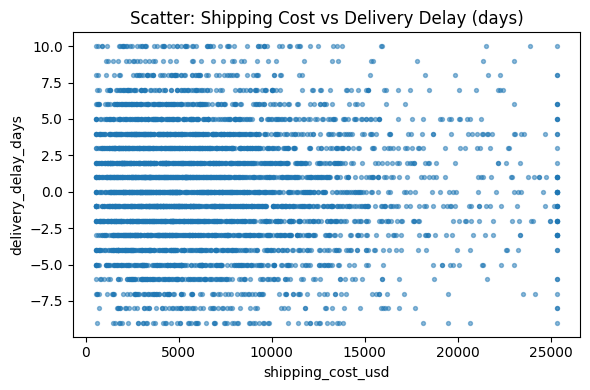

In [11]:
if "shipping_cost_usd" not in df.columns:
    raise KeyError("Expected numeric column 'shipping_cost_usd' in the cleaned dataset.")

# Cost summary by SLA outcome
cost_by_flag = df.groupby("sla_breach_flag")["shipping_cost_usd"].describe()
print("Shipping cost summary by sla_breach_flag:")
display(cost_by_flag)

# Box plot: cost by SLA flag
df_cost = df[["sla_breach_flag","shipping_cost_usd"]].copy()
df_cost["sla_breach_flag"] = df_cost["sla_breach_flag"].astype(int).astype(str)

plot_box(df_cost.rename(columns={"sla_breach_flag":"SLA (0=On-time,1=Breach)"}),
         "SLA (0=On-time,1=Breach)", "shipping_cost_usd",
         title="Shipping Cost Distribution: On-time vs Breach (box plot)", rotate=0)

# Correlation: cost vs delay
if "delivery_delay_days" in df.columns:
    corr_cost_delay = df[["shipping_cost_usd","delivery_delay_days"]].corr().iloc[0,1]
    print(f"Correlation (shipping_cost_usd vs delivery_delay_days): {corr_cost_delay:.4f}")

    # Scatter plot
    plot_scatter(df, "shipping_cost_usd", "delivery_delay_days", title="Scatter: Shipping Cost vs Delivery Delay (days)")


**Business interpretation:**  
- If breach shipments have **higher** cost, then cost may reflect reactive spending (expedite after issues) rather than preventing issues.  
- If cost and delay are weakly correlated, higher spend may not buy reliability—routing, carrier choice, and mode may matter more.


# 5️⃣ Shipment Attribute Impact

We analyze breach vs:
- **priority_flag**
- **fragile_flag**
- **shipment_weight_kg**
- **shipment_volume_cbm**

Goal: understand which shipment characteristics increase risk.


Flag columns found: ['priority_flag', 'fragile_flag']

=== priority_flag ===


,shipment_volume,breach_rate,avg_delay
priority_flag,,,
0,143934,0.485125,0.412932
1,56066,0.439571,-0.018264


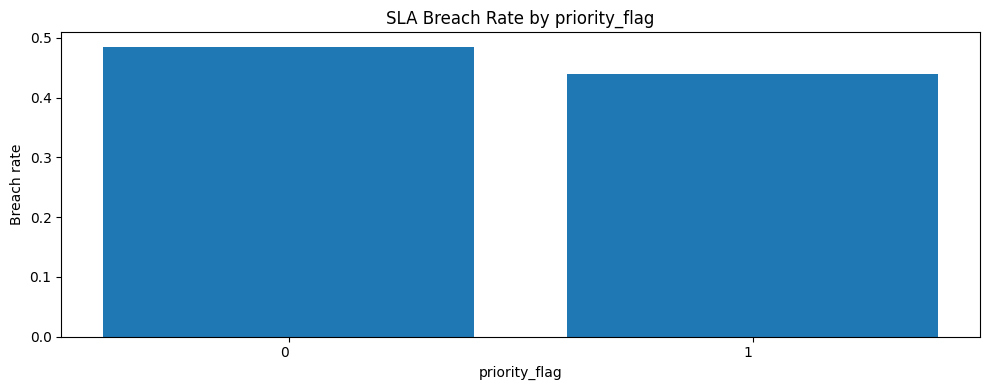


=== fragile_flag ===


,shipment_volume,breach_rate,avg_delay
fragile_flag,,,
1,36124,0.590881,1.458116
0,163876,0.446228,0.035014


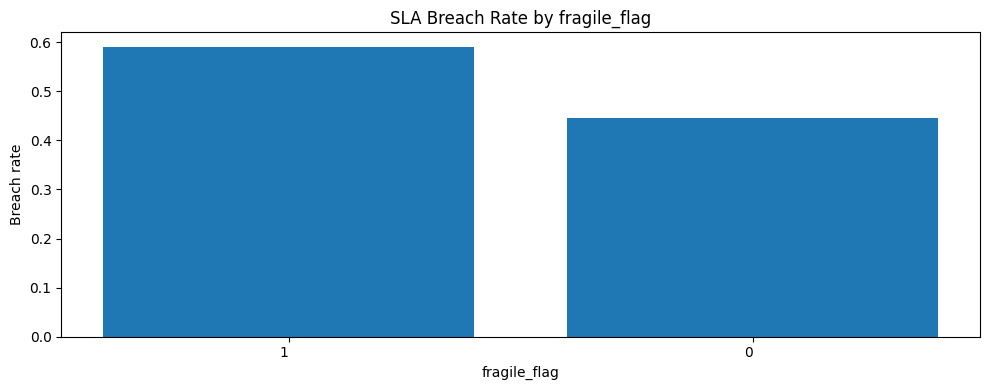


shipment_weight_kg summary by sla_breach_flag:


,count,mean,std,min,25%,50%,75%,max
sla_breach_flag,,,,,,,,
0,105529.0,6016.545379,3459.459743,129.7696,3022.27,6021.42,9011.290,11878.1219
1,94471.0,6005.173541,3458.296665,129.7696,3008.91,6015.46,8996.675,11878.1219


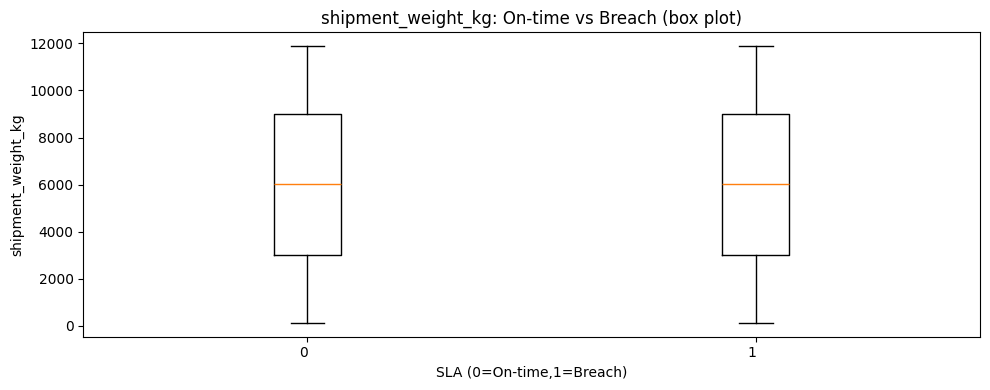


shipment_volume_cbm summary by sla_breach_flag:


,count,mean,std,min,25%,50%,75%,max
sla_breach_flag,,,,,,,,
0,105529.0,75.119949,43.266707,1.65,37.58,75.07,112.65,148.55
1,94471.0,74.954285,43.262979,1.65,37.35,75.04,112.31,148.55


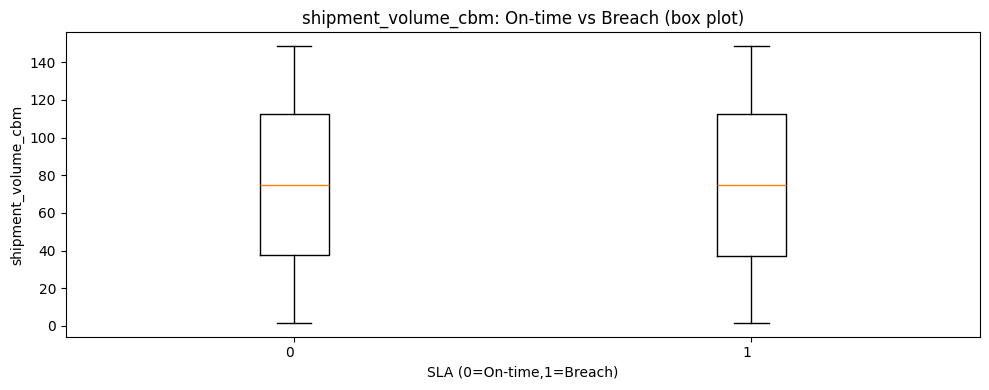

In [12]:
# Identify likely binary flag columns (priority & fragile)
flag_cols = []
for cand in ["priority_flag", "fragile_flag"]:
    if cand in df.columns:
        flag_cols.append(cand)

print("Flag columns found:", flag_cols)

# Breach rate by flags
for col in flag_cols:
    stats = df.groupby(col).agg(
        shipment_volume=(col, "size"),
        breach_rate=("sla_breach_flag","mean"),
        avg_delay=("delivery_delay_days","mean")
    ).sort_values("breach_rate", ascending=False)
    print(f"\n=== {col} ===")
    display(stats)
    plot_bar(stats["breach_rate"], title=f"SLA Breach Rate by {col}", xlabel=col, ylabel="Breach rate", top_n=None, rotate=0)

# Weight and volume vs breach
for num_col in ["shipment_weight_kg", "shipment_volume_cbm"]:
    if num_col in df.columns:
        desc = df.groupby("sla_breach_flag")[num_col].describe()
        print(f"\n{num_col} summary by sla_breach_flag:")
        display(desc)

        # Box plot by SLA flag
        tmp = df[[num_col, "sla_breach_flag"]].copy()
        tmp["sla_breach_flag"] = tmp["sla_breach_flag"].astype(int).astype(str)
        plot_box(tmp.rename(columns={"sla_breach_flag":"SLA (0=On-time,1=Breach)"}),
                 "SLA (0=On-time,1=Breach)", num_col,
                 title=f"{num_col}: On-time vs Breach (box plot)", rotate=0)


**Business interpretation:**  
- Priority shipments might have tighter promised lead times, which can increase recorded breach risk if operations do not adjust capacity.  
- Fragile shipments may require special handling, increasing handoffs and delays.  
- Heavier/larger shipments can be constrained by capacity, equipment, or consolidation schedules.


# 6️⃣ Basic Correlation Analysis (Numerical)

We compute a correlation matrix for numerical variables and focus on relationships with:
- `delivery_delay_days`
- `sla_breach_flag`

No feature creation.


Numeric columns:


['shipment_weight_kg',
 'shipment_volume_cbm',
 'priority_flag',
 'fragile_flag',
 'temperature_control_flag',
 'planned_delivery_days',
 'actual_delivery_days',
 'delivery_delay_days',
 'sla_breach_flag',
 'shipping_cost_usd',
 'fuel_surcharge_pct',
 'customs_delay_flag',
 'weather_disruption_flag',
 'shipment_value_usd',
 'insurance_flag']

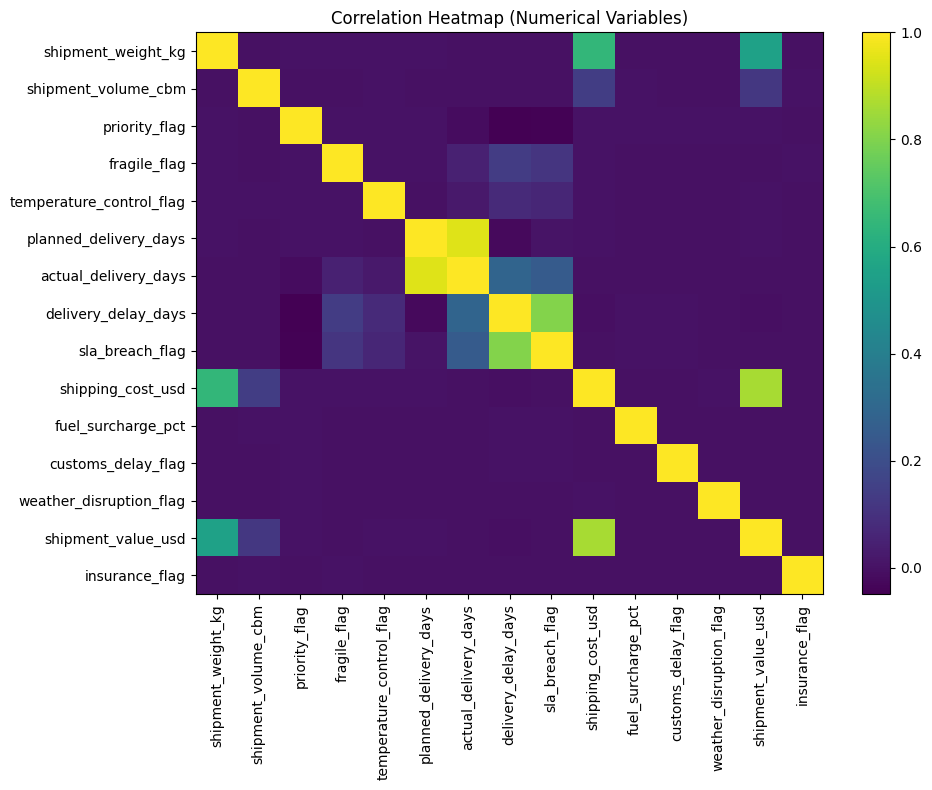


Top correlations with delivery_delay_days:


,delivery_delay_days
delivery_delay_days,1.000000
sla_breach_flag,0.807372
actual_delivery_days,0.287905
fragile_flag,0.138051
temperature_control_flag,0.077212
fuel_surcharge_pct,0.000997
customs_delay_flag,0.000355
insurance_flag,-0.000162
shipment_volume_cbm,-0.002026
weather_disruption_flag,-0.002104



Most negative correlations with delivery_delay_days:


,delivery_delay_days
fragile_flag,0.138051
temperature_control_flag,0.077212
fuel_surcharge_pct,0.000997
customs_delay_flag,0.000355
insurance_flag,-0.000162
shipment_volume_cbm,-0.002026
weather_disruption_flag,-0.002104
shipment_weight_kg,-0.003036
shipment_value_usd,-0.004176
shipping_cost_usd,-0.004733



Top correlations with sla_breach_flag:


,sla_breach_flag
sla_breach_flag,1.000000
delivery_delay_days,0.807372
actual_delivery_days,0.253864
fragile_flag,0.111468
temperature_control_flag,0.063925
planned_delivery_days,0.005091
customs_delay_flag,0.002456
fuel_surcharge_pct,0.000684
insurance_flag,0.000280
shipment_value_usd,-0.001578



Most negative correlations with sla_breach_flag:


,sla_breach_flag
fragile_flag,0.111468
temperature_control_flag,0.063925
planned_delivery_days,0.005091
customs_delay_flag,0.002456
fuel_surcharge_pct,0.000684
insurance_flag,0.000280
shipment_value_usd,-0.001578
shipment_weight_kg,-0.001641
shipment_volume_cbm,-0.001912
weather_disruption_flag,-0.002058


In [13]:
# Select numerical columns
num_df = df.select_dtypes(include=[np.number]).copy()

print("Numeric columns:")
display(list(num_df.columns))

# Correlation matrix
corr = num_df.corr(numeric_only=True)

# Heatmap
plot_heatmap(corr, title="Correlation Heatmap (Numerical Variables)")

# Focus: correlations with delay and breach
focus_cols = [c for c in ["delivery_delay_days","sla_breach_flag"] if c in corr.columns]
for target in focus_cols:
    rel = corr[target].sort_values(ascending=False)
    print(f"\nTop correlations with {target}:")
    display(rel.head(12))
    print(f"\nMost negative correlations with {target}:")
    display(rel.tail(12))


# EDA Summary (Paste into your report)

Use this section to create a **1–2 page EDA Summary**. Replace the bracketed text after running the notebook.

## Key Findings
- **Overall SLA breach rate:** `[XX%]` (Target imbalance: `[Yes/No]`)
- **High-risk carriers:** `[Carrier A, Carrier B, ...]` (High breach rate / high delay; check volume)
- **Stable carriers:** `[Carrier X, Carrier Y, ...]` (Low breach rate / low delay)
- **Risky shipping modes:** `[Mode ...]` (Higher breach rate)
- **Risky routes (origin → destination):** `[Route ...]` (Higher breach rate; ensure enough samples)
- **Cost vs reliability:** `[Higher cost reduces risk / does NOT reduce risk / unclear]`
- **Shipment attribute impacts:**  
  - Priority flag: `[Increases/Decreases] breach rate  
  - Fragile flag: `[Increases/Decreases] breach rate  
  - Weight / Volume: `[Higher/Larger increases risk?]`

## Business Interpretation (WHY it happens)
- `[Explain operational reasons based on the above patterns: carrier reliability, route complexity, mode constraints, capacity, handling, etc.]`

## What should guide modeling next week
- Prioritize these risk signals: **carrier**, **route**, **shipping mode**, and the strongest correlates of **delay** and **breach**.
- Consider imbalance-aware evaluation (precision/recall/F1/ROC-AUC) if the target is imbalanced.
